In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
shap.initjs()
from lime.lime_tabular import LimeTabularExplainer

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os



In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [3]:
## Load the joblib file stored in the models folder
fname = "../Models/prediction_sales.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [4]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [5]:
X_train.head()

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
8269        7.220          Regular         0.064142           Baking Goods   
7604        6.135          Low Fat         0.079294            Soft Drinks   
2762       12.150          Low Fat         0.028593              Household   
6464        5.945          Low Fat         0.093009              Household   
4707       18.200          Regular         0.066285  Fruits and Vegetables   

      Item_MRP  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
8269   61.2510                       1998         NaN               Tier 3   
7604  111.2860                       2009      Medium               Tier 3   
2762  151.0708                       2004       Small               Tier 2   
6464  127.8652                       2004       Small               Tier 2   
4707  247.2092                       2004       Small               Tier 2   

            Outlet_Type  
8269      Grocery Store  
7604  Supermarket Type2  
2762  Supermarket Type1  
6464  Supermarket Type1  
4707  Supermarket Type1

In [6]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         index=X_train.index,
                          columns=feature_names)
x_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        index=X_test.index,
                        columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
8269        7.220         0.064142   61.2510                     1998.0   
7604        6.135         0.079294  111.2860                     2009.0   
2762       12.150         0.028593  151.0708                     2004.0   
6464        5.945         0.093009  127.8652                     2004.0   
4707       18.200         0.066285  247.2092                     2004.0   

      Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
8269          1.0                   2.0                       0.0   
7604          1.0                   2.0                       1.0   
2762          0.0                   1.0                       1.0   
6464          0.0                   1.0                       1.0   
4707          0.0                   1.0                       0.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
8269                       1.0                     1.0               0.0  ...   
7604                       0.0                     0.0               0.0  ...   
2762                       0.0                     0.0               0.0  ...   
6464                       0.0                     0.0               0.0  ...   
4707                       1.0                     0.0               0.0  ...   

      Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  \
8269             0.0               0.0                0.0   
7604             0.0               0.0                0.0   
2762             0.0               0.0                0.0   
6464             0.0               0.0                0.0   
4707             0.0               0.0                0.0   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
8269                    0.0                    0.0                      0.0   
7604                    0.0                    1.0                      0.0   
2762                    0.0                    0.0                      0.0   
6464                    0.0                    0.0                      0.0   
4707                    0.0                    0.0                      0.0   

      Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
8269                        1.0                            0.0   
7604                        0.0                            0.0   
2762                        0.0                            1.0   
6464                        0.0                            1.0   
4707                        0.0                            1.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
8269                            0.0                            0.0  
7604                            1.0                            0.0  
2762                            0.0                            0.0  
6464                            0.0                            0.0  
4707                            0.0                            0.0  

[5 rows x 28 columns]

# Global Explainations

In [7]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_reg, x_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

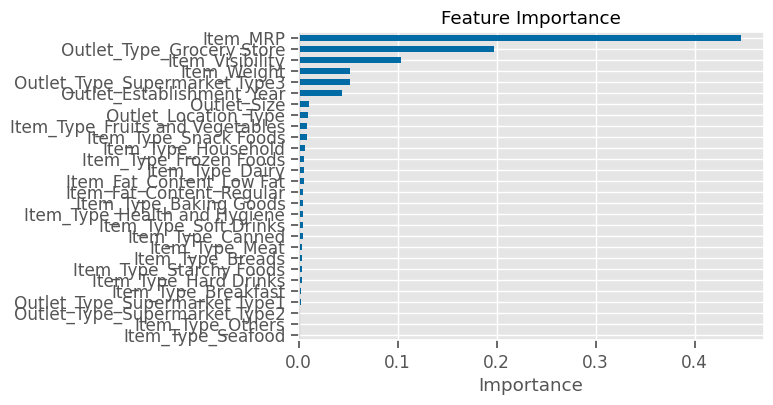

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [8]:
evaluate_regression(rf_reg, X_train_df, y_train, x_test_df, y_test)

importances = get_importances(rf_reg)
plot_importances(importances)

In [9]:
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)
perm_importances

Item_Weight                       -0.009979
Item_Visibility                   -0.001438
Item_MRP                           0.713548
Outlet_Establishment_Year          0.012555
Outlet_Size                        0.002226
Outlet_Location_Type               0.001789
Item_Fat_Content_Low Fat          -0.002781
Item_Fat_Content_Regular          -0.002327
Item_Type_Baking Goods            -0.001141
Item_Type_Breads                  -0.000922
Item_Type_Breakfast               -0.000533
Item_Type_Canned                   0.000222
Item_Type_Dairy                   -0.000235
Item_Type_Frozen Foods            -0.002670
Item_Type_Fruits and Vegetables   -0.001830
Item_Type_Hard Drinks             -0.000056
Item_Type_Health and Hygiene      -0.000728
Item_Type_Household               -0.002978
Item_Type_Meat                    -0.000346
Item_Type_Others                  -0.000500
Item_Type_Seafood                  0.000531
Item_Type_Snack Foods             -0.000196
Item_Type_Soft Drinks           

In [10]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         index=X_train.index,
                         columns=feature_names)

x_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        index=X_test.index,
                        columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
8269        7.220         0.064142   61.2510                     1998.0   
7604        6.135         0.079294  111.2860                     2009.0   
2762       12.150         0.028593  151.0708                     2004.0   
6464        5.945         0.093009  127.8652                     2004.0   
4707       18.200         0.066285  247.2092                     2004.0   

      Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
8269          1.0                   2.0                       0.0   
7604          1.0                   2.0                       1.0   
2762          0.0                   1.0                       1.0   
6464          0.0                   1.0                       1.0   
4707          0.0                   1.0                       0.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
8269                       1.0                     1.0               0.0  ...   
7604                       0.0                     0.0               0.0  ...   
2762                       0.0                     0.0               0.0  ...   
6464                       0.0                     0.0               0.0  ...   
4707                       1.0                     0.0               0.0  ...   

      Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  \
8269             0.0               0.0                0.0   
7604             0.0               0.0                0.0   
2762             0.0               0.0                0.0   
6464             0.0               0.0                0.0   
4707             0.0               0.0                0.0   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
8269                    0.0                    0.0                      0.0   
7604                    0.0                    1.0                      0.0   
2762                    0.0                    0.0                      0.0   
6464                    0.0                    0.0                      0.0   
4707                    0.0                    0.0                      0.0   

      Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
8269                        1.0                            0.0   
7604                        0.0                            0.0   
2762                        0.0                            1.0   
6464                        0.0                            1.0   
4707                        0.0                            1.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
8269                            0.0                            0.0  
7604                            1.0                            0.0  
2762                            0.0                            0.0  
6464                            0.0                            0.0  
4707                            0.0                            0.0  

[5 rows x 28 columns]

In [11]:
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [12]:
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
4469         7.72             0.07     76.40                   1,987.00   
4438         5.11             0.03    163.82                   2,004.00   
366          8.05             0.08    256.46                   2,004.00   
2219         8.76             0.05    128.33                   1,999.00   
6080         6.59             0.18     82.79                   1,998.00   

      Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
4469         2.00                  2.00                      0.00   
4438         0.00                  1.00                      1.00   
366          0.00                  1.00                      0.00   
2219         1.00                  0.00                      1.00   
6080         1.00                  2.00                      1.00   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
4469                      1.00                    0.00              1.00  ...   
4438                      0.00                    0.00              0.00  ...   
366                       1.00                    0.00              0.00  ...   
2219                      0.00                    0.00              0.00  ...   
6080                      0.00                    0.00              0.00  ...   

      Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  \
4469            0.00              0.00               0.00   
4438            0.00              0.00               0.00   
366             0.00              0.00               0.00   
2219            0.00              0.00               0.00   
6080            0.00              0.00               0.00   

      Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
4469                   0.00                   0.00                     0.00   
4438                   0.00                   0.00                     0.00   
366                    0.00                   0.00                     0.00   
2219                   0.00                   0.00                     0.00   
6080                   0.00                   0.00                     0.00   

      Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
4469                       0.00                           1.00   
4438                       0.00                           1.00   
366                        0.00                           1.00   
2219                       0.00                           1.00   
6080                       1.00                           0.00   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
4469                           0.00                           0.00  
4438                           0.00                           0.00  
366                            0.00                           0.00  
2219                           0.00                           0.00  
6080                           0.00                           0.00  

[5 rows x 28 columns]

In [14]:
rf_explainer = shap.Explainer(rf_reg)

rf_shap_values = rf_explainer(X_shap)

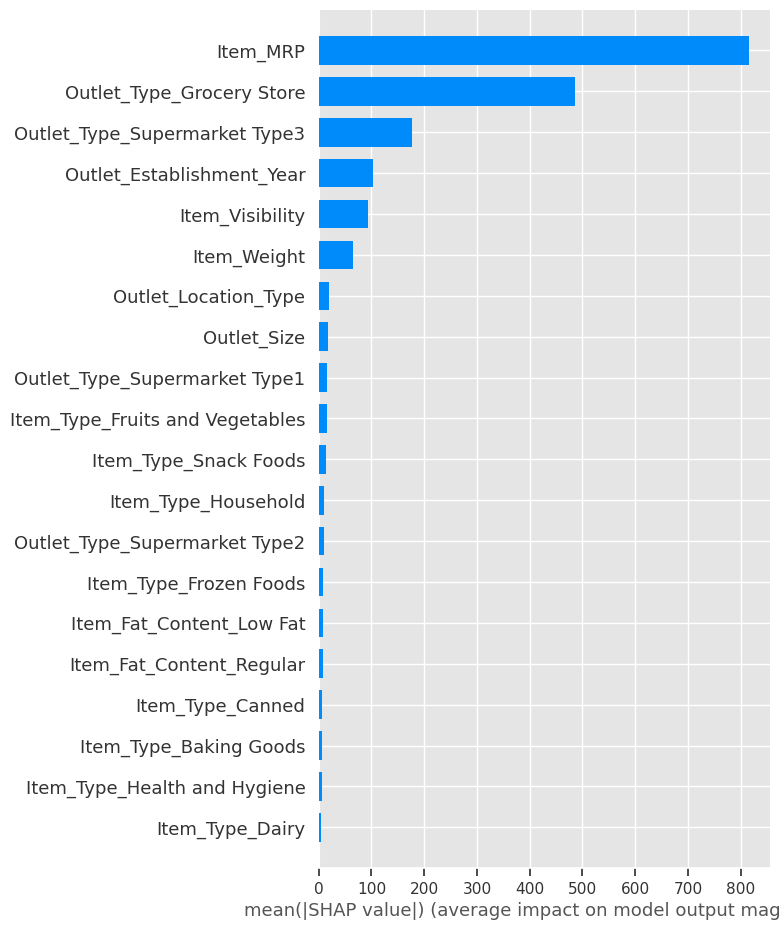

In [16]:
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar')

- This model has item visibility as a lower influence on the model's ability to the previous model.
- for the most part, the features are relatively the same.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


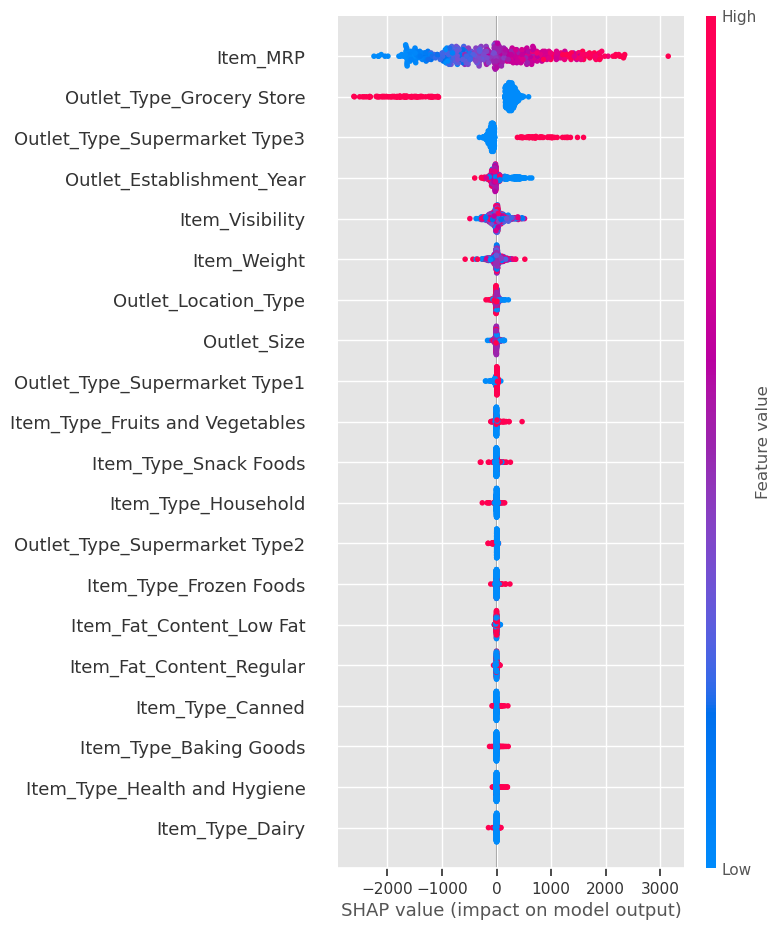

In [18]:
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='dot')

- The higher the MRP on the item, the higher the predicted item sales
- Grocery store types have a lower predicted item sales compared to supermarket
- The older the store, the lower the predicted item sales

# Local Explanations

In [19]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)
rf_shap_values = rf_explainer(X_shap)

In [20]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0         7.72             0.07     76.40                   1,987.00   
1         5.11             0.03    163.82                   2,004.00   
2         8.05             0.08    256.46                   2,004.00   
3         8.76             0.05    128.33                   1,999.00   
4         6.59             0.18     82.79                   1,998.00   

   Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
0         2.00                  2.00                      0.00   
1         0.00                  1.00                      1.00   
2         0.00                  1.00                      0.00   
3         1.00                  0.00                      1.00   
4         1.00                  2.00                      1.00   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
0                      1.00                    0.00              1.00  ...   
1                      0.00                    0.00              0.00  ...   
2                      1.00                    0.00              0.00  ...   
3                      0.00                    0.00              0.00  ...   
4                      0.00                    0.00              0.00  ...   

   Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0            0.00              0.00               0.00                   0.00   
1            0.00              0.00               0.00                   0.00   
2            0.00              0.00               0.00                   0.00   
3            0.00              0.00               0.00                   0.00   
4            0.00              0.00               0.00                   0.00   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Outlet_Type_Grocery Store  \
0                   0.00                     0.00                       0.00   
1                   0.00                     0.00                       0.00   
2                   0.00                     0.00                       0.00   
3                   0.00                     0.00                       0.00   
4                   0.00                     0.00                       1.00   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                           1.00                           0.00   
1                           1.00                           0.00   
2                           1.00                           0.00   
3                           1.00                           0.00   
4                           0.00                           0.00   

   Outlet_Type_Supermarket Type3  
0                           0.00  
1                           0.00  
2                           0.00  
3                           0.00  
4                           0.00  

[5 rows x 28 columns]

In [21]:
y_shap_local.describe()

count     500.00
mean    2,149.72
std     1,720.63
min        36.62
25%       747.53
50%     1,763.70
75%     3,043.04
max     9,371.80
Name: Item_Outlet_Sales, dtype: float64

## Lowest product sales

In [22]:
idx_low_sale= y_shap_local.idxmin()
idx_low_sale

178

In [23]:
X_shap_local.iloc[idx_low_sale]

Item_Weight                          15.35
Item_Visibility                       0.02
Item_MRP                             35.22
Outlet_Establishment_Year         1,998.00
Outlet_Size                           1.00
Outlet_Location_Type                  2.00
Item_Fat_Content_Low Fat              1.00
Item_Fat_Content_Regular              0.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                1.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        0.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_S

In [24]:
## Create a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')

lime_explainer

In [25]:
NUMBER_OF_FEATURES=20

exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_sale],
                                      rf_reg.predict, num_features=NUMBER_OF_FEATURES)
exp.show_in_notebook();

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


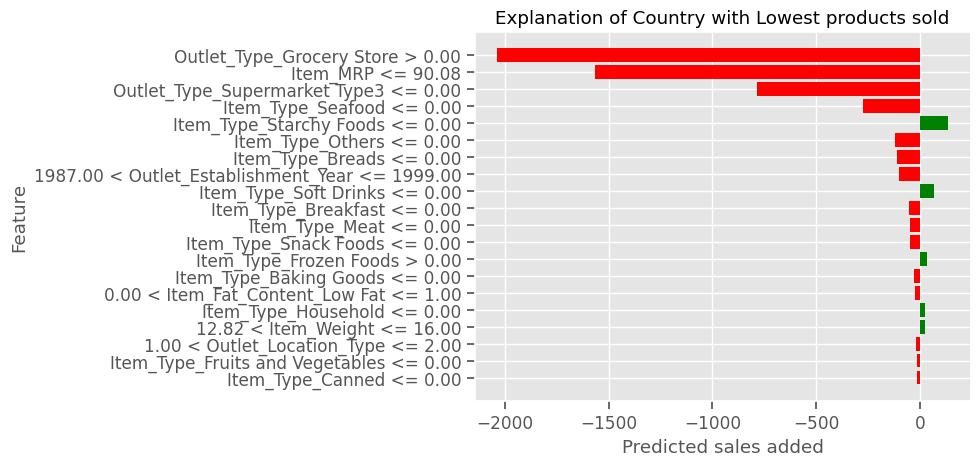

In [26]:
exp.as_pyplot_figure()
plt.title('Explanation of Country with Lowest products sold')
plt.xlabel('Predicted sales added')
plt.ylabel('Feature')
plt.savefig('low_sale_lime_explanation.png')

- The most heavily influenced feature for this product is that it is sold in a grocery store.

In [28]:
shap.force_plot(rf_explainer.expected_value, 
                shap_values = rf_shap_values[idx_low_sale].values,
                features=X_shap_local.iloc[idx_low_sale])
                

- The most heavily influenced feature according to the force plot is that it is also sold in a grocery store.

## Highest product sales

In [29]:
idx_high_sale = y_shap_local.idxmax()
idx_high_sale

482

In [30]:
X_shap_local.iloc[idx_high_sale]

Item_Weight                          12.82
Item_Visibility                       0.04
Item_MRP                            260.63
Outlet_Establishment_Year         1,985.00
Outlet_Size                           1.00
Outlet_Location_Type                  2.00
Item_Fat_Content_Low Fat              1.00
Item_Fat_Content_Regular              0.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       1.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        0.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_S

In [31]:
NUMBER_OF_FEATURES=20

exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_sale],
                                      rf_reg.predict, num_features=NUMBER_OF_FEATURES)
exp.show_in_notebook();

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


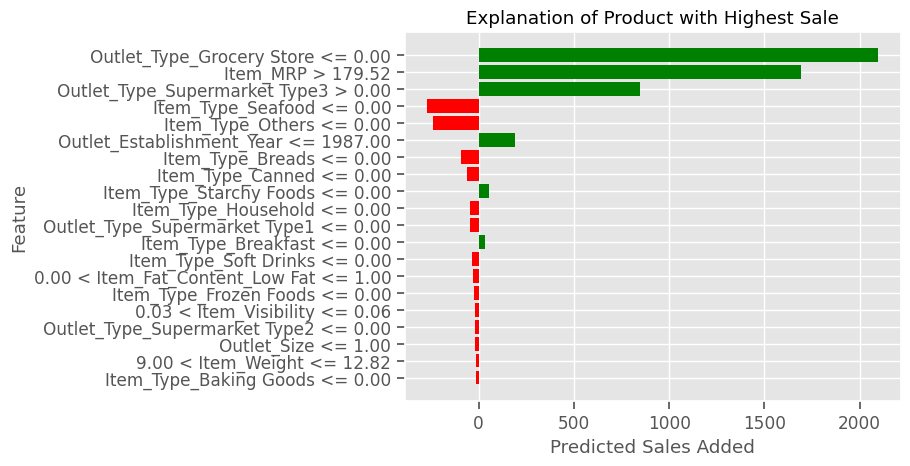

In [32]:
exp.as_pyplot_figure()
plt.title('Explanation of Product with Highest Sale')
plt.xlabel('Predicted Sales Added')
plt.ylabel('Feature')
plt.savefig('high_sale_explanation.png')

- The most heavily influenced feature for this product is that it is sold in a grocery store.
- the second highest influencer is the products MRP

In [34]:
shap.force_plot(rf_explainer.expected_value, 
                shap_values = rf_shap_values[idx_high_sale].values,
                features=X_shap_local.iloc[idx_high_sale])

- The most heavily influenced feature for this product is that it is sold in a grocery store.